load packages

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt 
import matplotlib.patches as mpatches


load data

In [80]:
file_path = '../data/StockAnalysisDataset.csv'
data = pd.read_csv(file_path, parse_dates=['date'], index_col='date')
data.info()
data.head()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3020 entries, 2015-01-02 to 2017-12-29
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    3020 non-null   float64
 1   high    3020 non-null   float64
 2   low     3020 non-null   float64
 3   close   3020 non-null   float64
 4   volume  3020 non-null   int64  
 5   Name    3020 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 165.2+ KB


,open,high,low,close,volume,Name
date,,,,,,
2015-01-02,111.39,111.44,107.350,109.33,53204626,AAPL
2015-01-05,108.29,108.65,105.410,106.25,64285491,AAPL
2015-01-06,106.54,107.43,104.630,106.26,65797116,AAPL
2015-01-07,107.20,108.20,106.695,107.75,40105934,AAPL
2015-01-08,109.23,112.15,108.700,111.89,59364547,AAPL


## Isolate Data by Tickers

In [69]:
def get_ticker(data, ticker=None):
    """
    Returns closing prices for the whole DataFrame or for a specific ticker.
    """
    if ticker:
        filtered = data[data["Name"] == ticker]
        return filtered["close"]
    else:
        return data["close"]

In [71]:
# create a function to filter out prices solely based on ticker name
# get the closing prices 

def get_closing_prices(data, ticker=None):
    """
    Returns closing prices for the whole DataFrame or for a specific ticker.
    """
    if ticker:
        filtered = data[data["Name"] == ticker]
        return filtered["close"]
    else:
        return data["close"]

''' example:
prices = get_closing_prices(data, "AMZN")
print(prices) '''
prices = get_closing_prices(data, "AMZN")

## 1. Daily Returns

In [48]:
# TODO: Implement the logic for calculating returns.
def calculate_returns(data: pd.Series, ticker: str):    
    filtered = data[data["Name"] == ticker]
    filtered = filtered.copy()
    filtered['daily_return'] = ((filtered['close'] - filtered['open']) / filtered['open']) * 100
    print(f" \n--- DataFrame for {ticker} with new 'daily_return' column ---")
    print(filtered.head())

calculate_returns(data, "AMZN")

 
--- DataFrame for AMZN with new 'daily_return' column ---
              open    high       low   close   volume  Name  daily_return
date                                                                     
2015-01-02  312.58  314.75  306.9601  308.52  2788101  AMZN     -1.298867
2015-01-05  307.01  308.38  300.8500  302.19  2774231  AMZN     -1.569981
2015-01-06  302.24  303.00  292.3800  295.29  3519034  AMZN     -2.299497
2015-01-07  297.50  301.28  295.3300  298.42  2640349  AMZN      0.309244
2015-01-08  300.32  303.14  296.1100  300.46  3088398  AMZN      0.046617


## 2. Simple Moving Average (SMA)

In [ ]:
def calculate_sma(data: pd.Series, window:int, ticker: str): 
    
    filtered = data[data["Name"] == ticker]
    filtered = filtered.copy()
    SMA = pd.DataFrame()
    SMA['Close_Price'] = filtered['close'].rolling(window = window).mean().round(2) 
    return SMA
calculate_sma(data, 30, "AMZN")

,Close_Price
date,
2015-01-02,NaN
2015-01-05,NaN
2015-01-06,NaN
2015-01-07,NaN
2015-01-08,NaN
...,...
2017-12-22,1159.43
2017-12-26,1161.14
2017-12-27,1162.91


## 3. Upward and Downward Runs 

In [73]:
# create a function to filter out prices solely based on ticker name
# get the closing prices 

def get_closing_prices(data, ticker=None):
    """
    Returns closing prices for the whole DataFrame or for a specific ticker.
    """
    if ticker:
        filtered = data[data["Name"] == ticker]
        return filtered["close"]
    else:
        return data["close"]

''' example:
prices = get_closing_prices(data, "AMZN")
print(prices) '''
prices = get_closing_prices(data, "AMZN")

In [74]:
def calculate_runs():
    # daily changes in closing prices
    changes = prices.diff()

    # upward, no change, downward (1, 0, -1)
    # limitation - mainly directional; ignores magnitude (Use RSI)
    direction = np.where(changes > 0, 1, np.where(changes < 0, -1, 0))

    # initialise run count
    runs = []
    current_run_length = 1
    
    # prevent indexerror
    current_direction = direction[0] if len(direction) > 0 else 0
    

    # check if current direction is the same as indexed direction, if it is continue run count
    for i in range(1, len(direction)):
        if direction[i] == current_direction and direction[i] != 0:
            # Continue current run
            current_run_length += 1
        else:
            # End current run, start new one
            if current_direction != 0:  # we're not tracking zero runs
                runs.append({
                    'start_date': prices.index[i - current_run_length],
                    'end_date': prices.index[i - 1],
                    'direction': 'Up' if current_direction == 1 else 'Down',
                    'length': current_run_length,
                    'start_index': i - current_run_length,
                    'end_index': i - 1
                })
            current_run_length = 1
            current_direction = direction[i]

    # Close the loop, record the final run
    if current_direction != 0:
        runs.append({
            'start_date': prices.index[len(prices) - current_run_length],
            'end_date': prices.index[-1],
            'direction': 'Up' if current_direction == 1 else 'Down',
            'length': current_run_length,
            'start_index': len(prices) - current_run_length,
            'end_index': len(prices) - 1
        })

    return pd.DataFrame(runs), direction
    
runs_df, direction = calculate_runs()


In [75]:
def get_significant_runs(runs_df, min_length=5):
    # To filter out runs based on length depending on trading methodology
    significant = runs_df[runs_df['length'] >= min_length]
    up_runs = significant[significant['direction'] == 'Up']
    down_runs = significant[significant['direction'] == 'Down']

    return {
        'notable_up_runs': up_runs,
        'notable_down_runs': down_runs
    }

# Can use this to extract notable_up_runs or notable_down_runs
significant_runs = get_significant_runs(runs_df)
print(significant_runs)

{'notable_up_runs':     start_date   end_date direction  length  start_index  end_index
93  2015-09-15 2015-09-21        Up       5          176        180
103 2015-10-22 2015-10-29        Up       6          203        208
145 2016-02-10 2016-02-17        Up       5          278        282
163 2016-04-08 2016-04-18        Up       7          318        324
171 2016-05-06 2016-05-12        Up       5          338        342
195 2016-06-28 2016-07-06        Up       6          374        379
205 2016-08-04 2016-08-12        Up       7          400        406
239 2016-11-15 2016-11-22        Up       6          472        477
253 2017-01-03 2017-01-09        Up       5          504        508
263 2017-02-07 2017-02-13        Up       5          528        532
283 2017-03-27 2017-04-05        Up       8          561        568
291 2017-04-24 2017-05-01        Up       6          580        585
299 2017-05-18 2017-05-30        Up       8          598        605
321 2017-07-14 2017-07-20   

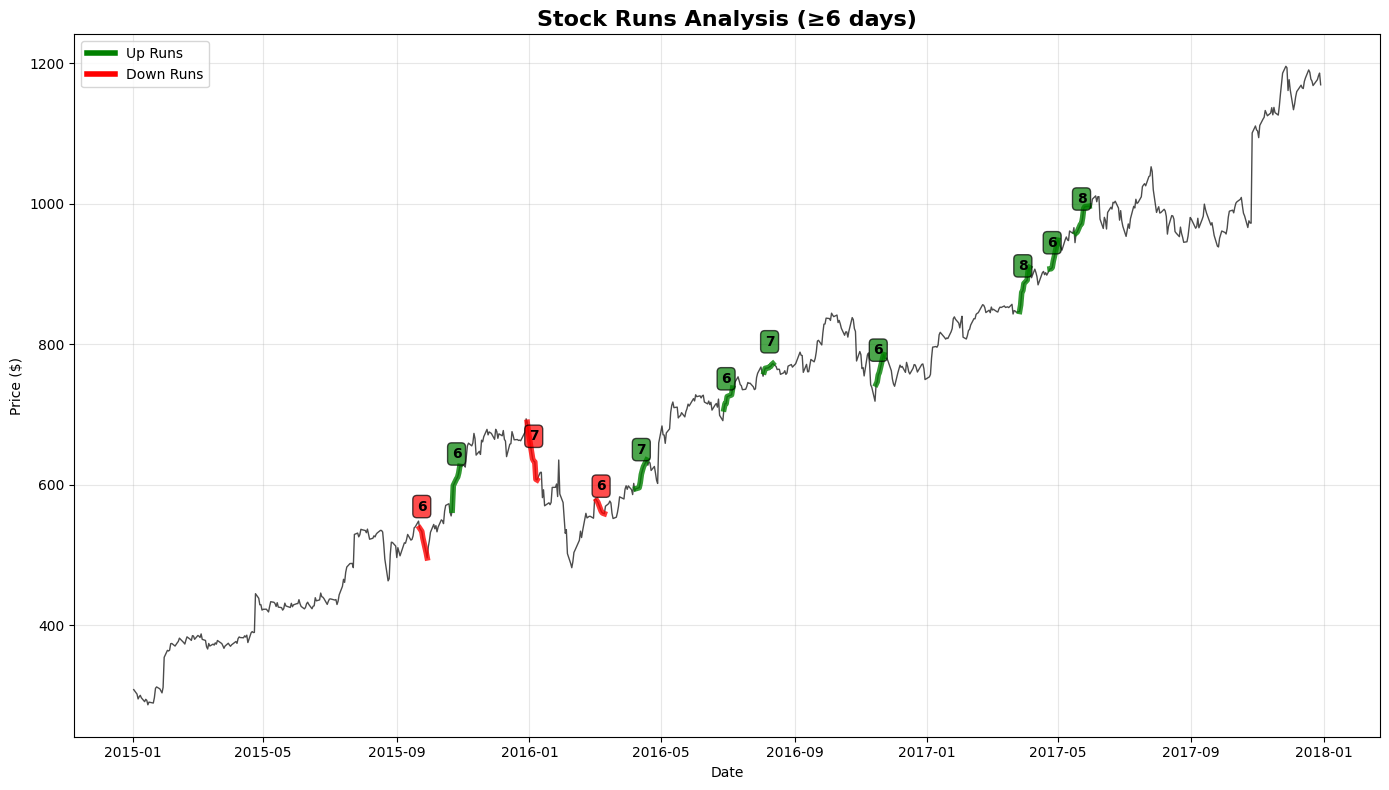

In [79]:
def plot_runs(prices, runs_df, min_length=5):
    """
    Simple plot with colored lines for significant runs
    
    Parameters:
    prices (pd.Series): Price data
    runs_df (pd.DataFrame): Runs data
    min_length (int): Minimum run length to highlight
    """
    plt.figure(figsize=(14, 8))
    
    # Plot price line
    plt.plot(prices.index, prices.values, 'black', linewidth=1, alpha=0.7)
    
    # Filter significant runs
    significant_runs = runs_df[runs_df['length'] >= min_length]
    
    # Draw colored lines for significant runs
    for i, run in significant_runs.iterrows():
        start_idx = run['start_index']
        end_idx = run['end_index']
        
        # Get the price segment for this run
        run_dates = prices.index[start_idx:end_idx+1]
        run_prices = prices.iloc[start_idx:end_idx+1]
        
        # Choose color and draw thick line
        color = 'green' if run['direction'] == 'Up' else 'red'
        plt.plot(run_dates, run_prices, color=color, linewidth=4, alpha=0.8)
        
        # Add run length label
        mid_idx = start_idx + (end_idx - start_idx) // 2
        plt.annotate(f"{run['length']}", 
                    xy=(prices.index[mid_idx], prices.iloc[mid_idx]),
                    xytext=(0, 15), textcoords='offset points',
                    ha='center', fontsize=10, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor=color, alpha=0.7))
    
    plt.title(f'Stock Runs Analysis (≥{min_length} days)', fontsize=16, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.grid(True, alpha=0.3)
    
    # Simple legend
    if len(significant_runs[significant_runs['direction'] == 'Up']) > 0:
        plt.plot([], [], 'green', linewidth=4, label='Up Runs')
    if len(significant_runs[significant_runs['direction'] == 'Down']) > 0:
        plt.plot([], [], 'red', linewidth=4, label='Down Runs')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


plot_runs(prices, runs_df, 6)